In [1]:
from PSDRegressor import PSDRegressor

In [2]:
import pycbc
import numpy as np
import scipy
import matplotlib.pyplot as plt
from pycbc.frame import read_frame
from pycbc.psd import welch, interpolate
from pycbc.filter import highpass, matched_filter,lowpass
from tqdm import tqdm

In [3]:
from pycbc.waveform import get_fd_waveform
from gstlal_psd import partition_time_series, block_transform

In [4]:
#read in data
channel_name = "H1:GWOSC-4KHZ_R1_STRAIN"
h1 = read_frame('H-H1_GWOSC_O3b_4KHZ_R1-1257852928-4096.gwf', channel_name)
h11 = np.nan_to_num(h1,nan=0)
h11 = np.nan_to_num(h1,nan=0)
h1 = pycbc.types.timeseries.TimeSeries(h11, delta_t=h1.delta_t)
h1 = highpass(h1, 10, 8)
psd2 = interpolate(welch(h1,seg_len = int((1/h1.delta_t)*8),seg_stride = int((1/h1.delta_t)*4)),1/h1.duration)

In [5]:
print(h1.delta_t)

0.000244140625


In [6]:
f_sample = float(1/h1.delta_f)
N = int(f_sample*32)
Z = int(f_sample*8)
n_med = 7
n_avg = 64

In [16]:
#partition the input data strain
data_blocks = partition_time_series(h1, N, Z)
#transform each block of data
transformed_block = block_transform(data_blocks,Z)

In [17]:
# Create a PSDRegressor object
psd_regressor = PSDRegressor(average_samples=n_avg, median_samples=n_med)

In [18]:
for i in tqdm(range(len(transformed_block))):
    psd_regressor.add_sample(transformed_block[i])

# Get the current PSD estimate
psd_estimate = psd_regressor.get_psd()
print(psd_estimate)


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 509/509 [04:09<00:00,  2.04it/s]

[1.92009260e-52 2.13182719e-52 1.92281809e-52 ... 2.13860946e-52
 1.92281809e-52 2.13182719e-52]


Interpolate to desire delta f

In [10]:
#adjust the frequency resolution
psd_estimate = pycbc.types.frequencyseries.FrequencySeries(psd_estimate, delta_f = 1/(len(transformed_block[0])*h1.delta_t))

# Ensure the PSD is in the correct format
psd_estimate_interpolated = interpolate(psd_estimate, 1/h1.duration)

In [11]:
print(len(psd2))
print(len(psd_estimate_interpolated)//2)

8388609
8388544


## Compute the reference PSD

In [12]:
#partition the input data strain
data_blocks = partition_time_series(h1, N, 0)
#transform each block of data
transformed_block = block_transform(data_blocks,0)

In [13]:
# Create a PSDRegressor object
psd_regressor = PSDRegressor(average_samples=n_avg, median_samples=n_med)

In [14]:
for i in tqdm(range(len(transformed_block))):
    psd_regressor.add_sample(transformed_block[i])

# Get the current PSD estimate
reference_psd = psd_regressor.get_psd()
print(reference_psd)


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 255/255 [02:03<00:00,  2.06it/s]

[5.50984651e-54 5.51385375e-54 5.52579649e-54 ... 5.54549293e-54
 5.52579649e-54 5.51385375e-54]


In [19]:
reference_psd = pycbc.types.frequencyseries.FrequencySeries(reference_psd, delta_f = 1/(len(transformed_block[0])*h1.delta_t))
print(len(reference_psd))
#interpolate reference psd
reference_psd_interpolated = interpolate(reference_psd, h1.delta_f)

131072


In [30]:
reference_psd_interpolated.resize(len(psd2))

In [31]:
print(len(reference_psd_interpolated))

8388609


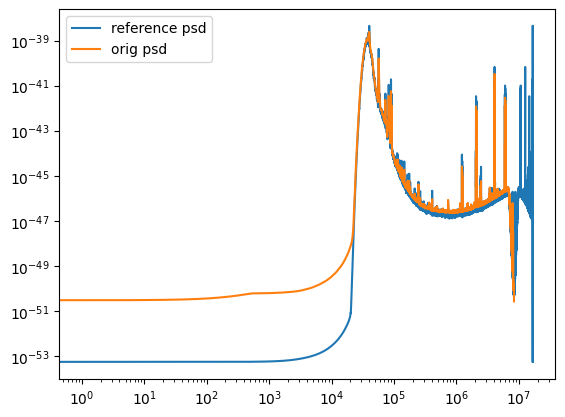

In [20]:
plt.loglog(reference_psd_interpolated, label = 'reference psd')
plt.loglog(psd2, label = 'orig psd')
#plt.loglog(psd_estimate, label = 'estimated psd')
plt.legend()


## Compute SNR

Compute with original PSD

In [21]:
ra = 5.3
dec = 4.5
psi = 2.6
tgps = 0
det_H1 = pycbc.detector.Detector('H1')
#antennna sensitivity
fp, fc = det_H1.antenna_pattern(right_ascension=ra, declination=dec, polarization=psi, t_gps=tgps)
#frequency range
minf = 20

mass1_det_frame = 100
mass2_det_frame = 100
distance_inj = 4500.  # in Mpc
inclination_inj = np.pi/4
phase_inj = 0.
flow = 20.
t0_inj = 300
fmax = 1600
# generate waveform
hpf, hcf = get_fd_waveform(approximant="IMRPhenomD",
                                        mass1 = mass1_det_frame,
                                        mass2 = mass2_det_frame,
                                        distance = distance_inj,
                                        inclination = inclination_inj,
                                        coa_phase = phase_inj,
                                        f_lower=flow, f_final=1/(2*h1.delta_t),
                                        delta_f=h1.delta_f)

template = fp*hpf + fc*hcf

In [22]:
SNR_orig_psd = matched_filter(template, h1, psd=psd2, low_frequency_cutoff=10.0)

Compute with gstlal psd

In [23]:
whiten_psd = np.sqrt(psd_estimate)*np.sqrt(reference_psd)
    
#adjust the frequency resolution
whiten_psd = pycbc.types.frequencyseries.FrequencySeries(whiten_psd, delta_f = 1/(len(transformed_block[0])*h1.delta_t))

# Ensure the PSD is in the correct format
whiten_psd = interpolate(whiten_psd, h1.delta_f)

whiten_psd.resize(len(h1)//2 +1)

    # Compute the SNR time series
snr = matched_filter(template, h1, psd=whiten_psd, low_frequency_cutoff=10.0)

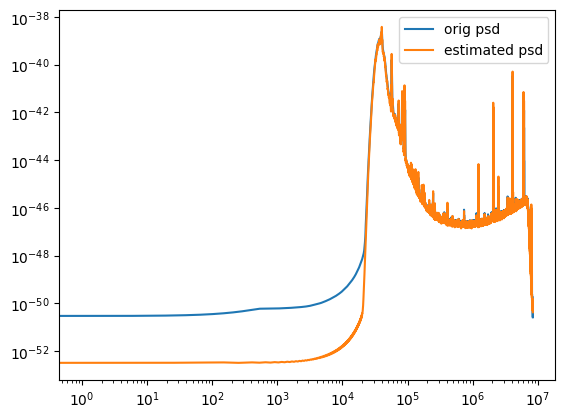

In [26]:
plt.loglog(psd2, label = 'orig psd')
plt.loglog(whiten_psd, label = 'estimated psd')
plt.legend()

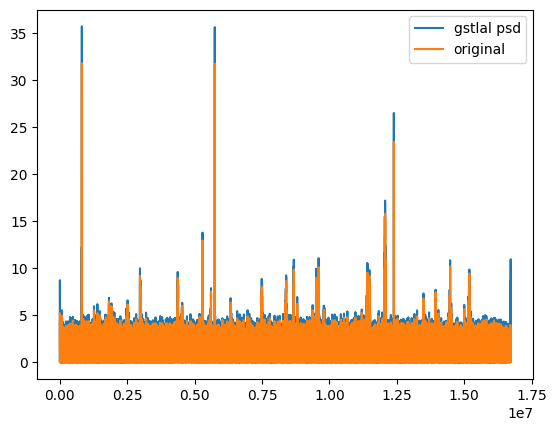

In [28]:
SNR_orig_psd_cropped = SNR_orig_psd.crop(4+4,4)
snr_cropped = snr.crop(4+4,4)
plt.plot(abs(snr_cropped), label = 'gstlal psd')
plt.plot(abs(SNR_orig_psd_cropped), label = 'original')
plt.legend()

Text(0.5, 0, '$|z|^{2}$')

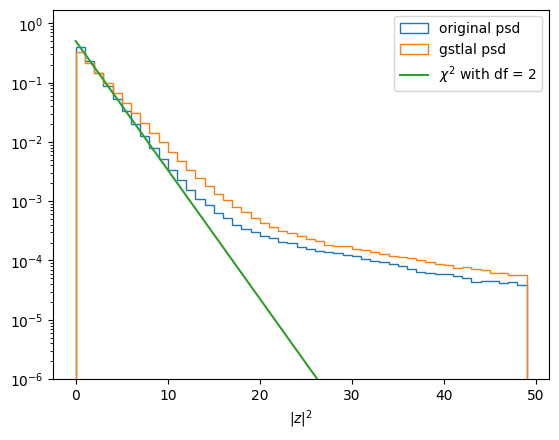

In [25]:
bins = np.arange(50)
plt.hist(abs(SNR_orig_psd)**2, histtype = 'step', bins = bins,density = True , label = 'original psd')
plt.hist(abs(snr)**2, histtype = 'step', bins = bins,density = True, label = 'gstlal psd')
plt.plot(np.arange(50), 0.5*np.exp(-0.5*np.arange(50)), label = '$\chi ^{2}$ with df = 2')
plt.yscale('log')
plt.ylim(bottom=1e-6)
plt.legend()
plt.xlabel('$|z|^{2}$')